### Import Dataset

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", DATASET_PATH)

100%|██████████| 612M/612M [00:02<00:00, 224MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


### Import Library

In [ ]:
!pip install wandb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import wandb
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from skimage import feature

### Init WanDB

In [ ]:
wandb.init(
    project="Traffic Sign Classification",
    name="HOG+ColorHist+SVC",
    config={
        "model": "SVC",
        "pca_components": 100,
        "svc_kernel": "rbf",
        "svc_c": 1.0,
        "svc_gamma": "scale",
    },
)
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Traffic Sign Label Definitions

In [ ]:
CLASS_LABELS = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

### Load Data

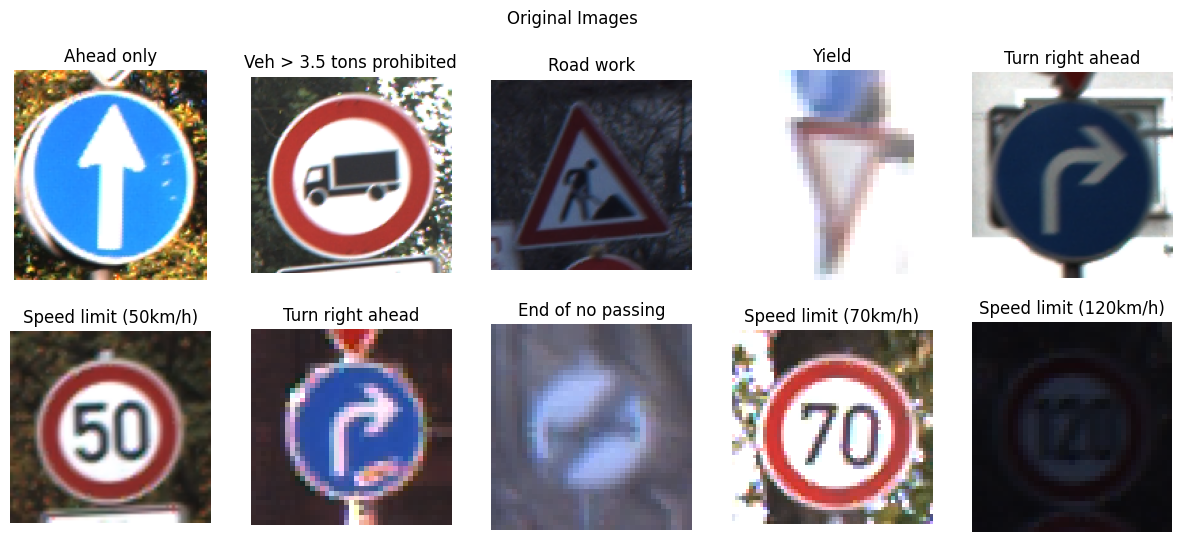

In [ ]:
def _load_images_and_labels(csv_file):
  images, labels = [], csv_file['ClassId'].values
  for path in csv_file['Path']:
      img = cv2.imread(os.path.join(DATASET_PATH, path))
      images.append(img)
  return images, labels

def load_data():
  train_csv = pd.read_csv(os.path.join(DATASET_PATH, "Train.csv"))
  test_csv = pd.read_csv(os.path.join(DATASET_PATH, "Test.csv"))
  meta_csv = pd.read_csv(os.path.join(DATASET_PATH, "Meta.csv"))

  train_images, train_labels = _load_images_and_labels(train_csv)
  test_images, test_labels = _load_images_and_labels(test_csv)
  meta_images, meta_labels = _load_images_and_labels(meta_csv)

  # Combine meta images into the training data
  train_images.extend(meta_images)
  train_labels = np.concatenate((train_labels, meta_labels), axis=0)

  # Shuffle the training and testing datasets to randomize them
  train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
  test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

  # Plotting
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  for i, ax in enumerate(axes.flat):
      ax.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
      ax.set_title(f'{CLASS_LABELS[train_labels[i]]}')
      ax.axis('off')
  plt.suptitle('Original Images')
  plt.show()

  return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_data()

In [ ]:
total_len = (len(train_images) + len(test_images))

print(f"Train dataset: {len(train_images)} ({len(train_images) / total_len * 100:.2f}%)")
print(f"Test dataset: {len(test_images)} ({len(test_images) / total_len * 100:.2f}%)")

Train dataset: 39252 (75.66%)
Test dataset: 12630 (24.34%)


### Preprocessing Data

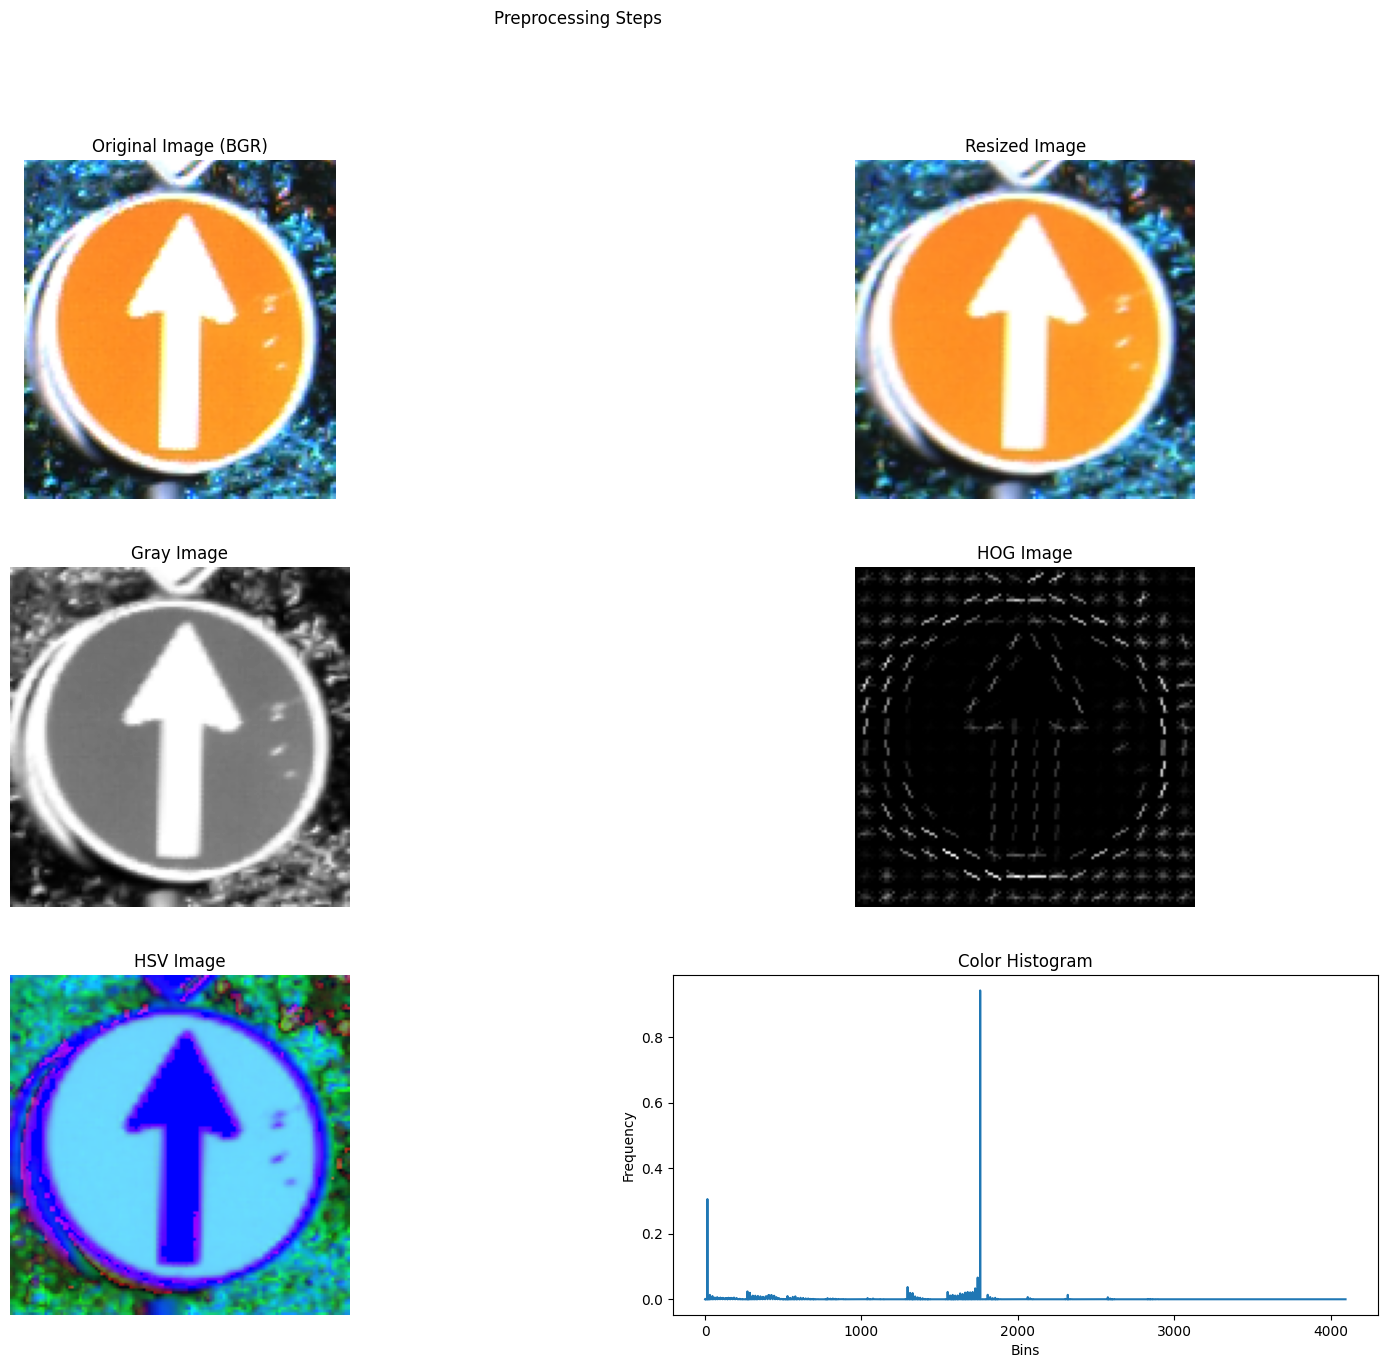

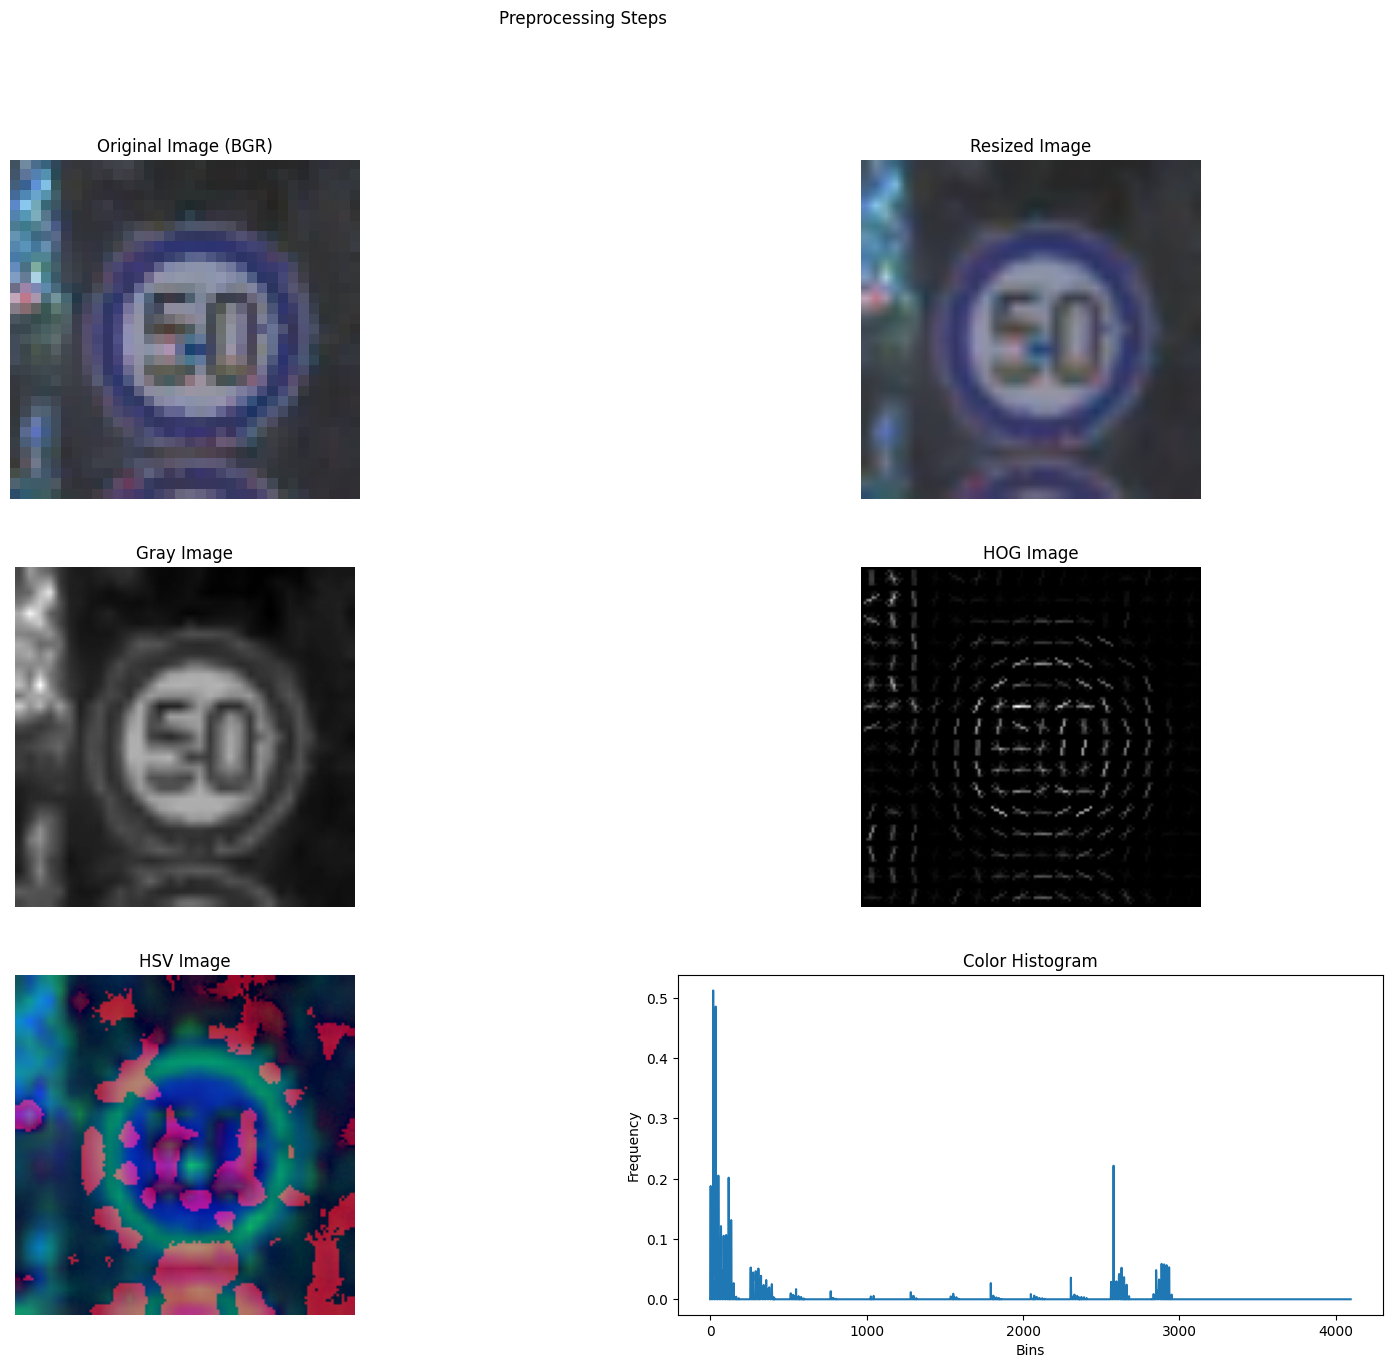

In [ ]:
def _plot_preprocessing_steps(image):
  plt.figure(figsize=(20, 15))

  # Original Image (BGR)
  plt.subplot(3, 2, 1)
  plt.imshow(image)
  plt.title('Original Image (BGR)')
  plt.axis('off')

  # Resize Image
  resized_image = cv2.resize(image, (128, 128))
  plt.subplot(3, 2, 2)
  plt.imshow(resized_image)
  plt.title('Resized Image')
  plt.axis('off')

  # Gray Image
  gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
  plt.subplot(3, 2, 3)
  plt.imshow(gray_image, cmap='gray')
  plt.title('Gray Image')
  plt.axis('off')

  # HOG Image
  _, hog_image = feature.hog(gray_image, visualize=True)
  plt.subplot(3, 2, 4)
  plt.imshow(hog_image, cmap='gray')
  plt.title('HOG Image')
  plt.axis('off')

  # HSV Image
  hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
  plt.subplot(3, 2, 5)
  plt.imshow(hsv_image)
  plt.title('HSV Image')
  plt.axis('off')

  # Color Histogram
  bins = (16, 16, 16)
  hist_range = (0, 256, 0, 256, 0, 256)
  hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, hist_range)
  hist = cv2.normalize(hist, hist).flatten()
  plt.subplot(3, 2, 6)
  plt.plot(hist)
  plt.title('Color Histogram')
  plt.xlabel('Bins')
  plt.ylabel('Frequency')
  plt.axis('on')

  plt.suptitle('Preprocessing Steps')
  plt.show()

def preprocess_and_extract_features_data(images):
  _plot_preprocessing_steps(images[0])
  print()

  processed_data = []
  hog = cv2.HOGDescriptor()

  bins = (16, 16, 16)
  hist_range = (0, 256, 0, 256, 0, 256)

  for img in images:
      img = cv2.resize(img, (128, 128))

      # Extract HOG features
      gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      hog_features = hog.compute(gray_image).flatten()

      # Add color hist
      hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
      hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, hist_range)
      hist = cv2.normalize(hist, hist).flatten()
      features = np.concatenate([hog_features, hist])

      processed_data.append(features)

  return np.array(processed_data)

train_features = preprocess_and_extract_features_data(train_images)
test_features = preprocess_and_extract_features_data(test_images)

### Apply PCA for dimensionality reduction

In [ ]:
print(f"💡 Data shape before PCA: {train_features.shape}")

pca = PCA(n_components=config.pca_components)
reduced_train_features = pca.fit_transform(train_features)

print(f"💡 Data shape after PCA: {reduced_train_features.shape}")

💡 Data shape before PCA: (39252, 38116)
💡 Data shape after PCA: (39252, 100)


### Train an SVM model

In [ ]:
svc = SVC(kernel=config.svc_kernel, C=config.svc_c, gamma=config.svc_gamma)
svc.fit(reduced_train_features, train_labels)

SVC()

### Evaluate the model using test data

In [ ]:
# Transform the test features using the PCA model to reduce dimensionality
X_test_pca = pca.transform(test_features)

y_pred = svc.predict(X_test_pca)

classification_metrics = {
    'accuracy': accuracy_score(test_labels, y_pred),
    'precision': precision_score(test_labels, y_pred, average='macro'),
    'recall': recall_score(test_labels, y_pred, average='macro'),
    'f1_score': f1_score(test_labels, y_pred, average='macro')
}

In [ ]:
print("💡 Classification Metrics:")
for metric, value in classification_metrics.items():
    print(f"{metric}: {value}")

💡 Classification Metrics:
accuracy: 0.9488519398258115
precision: 0.9489046575786689
recall: 0.9283999591016779
f1_score: 0.9368750772412138


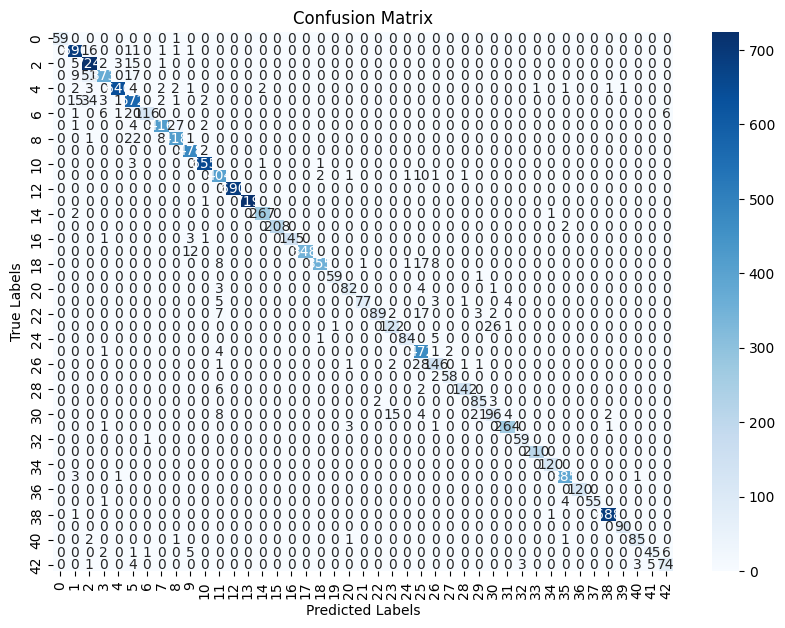

In [ ]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

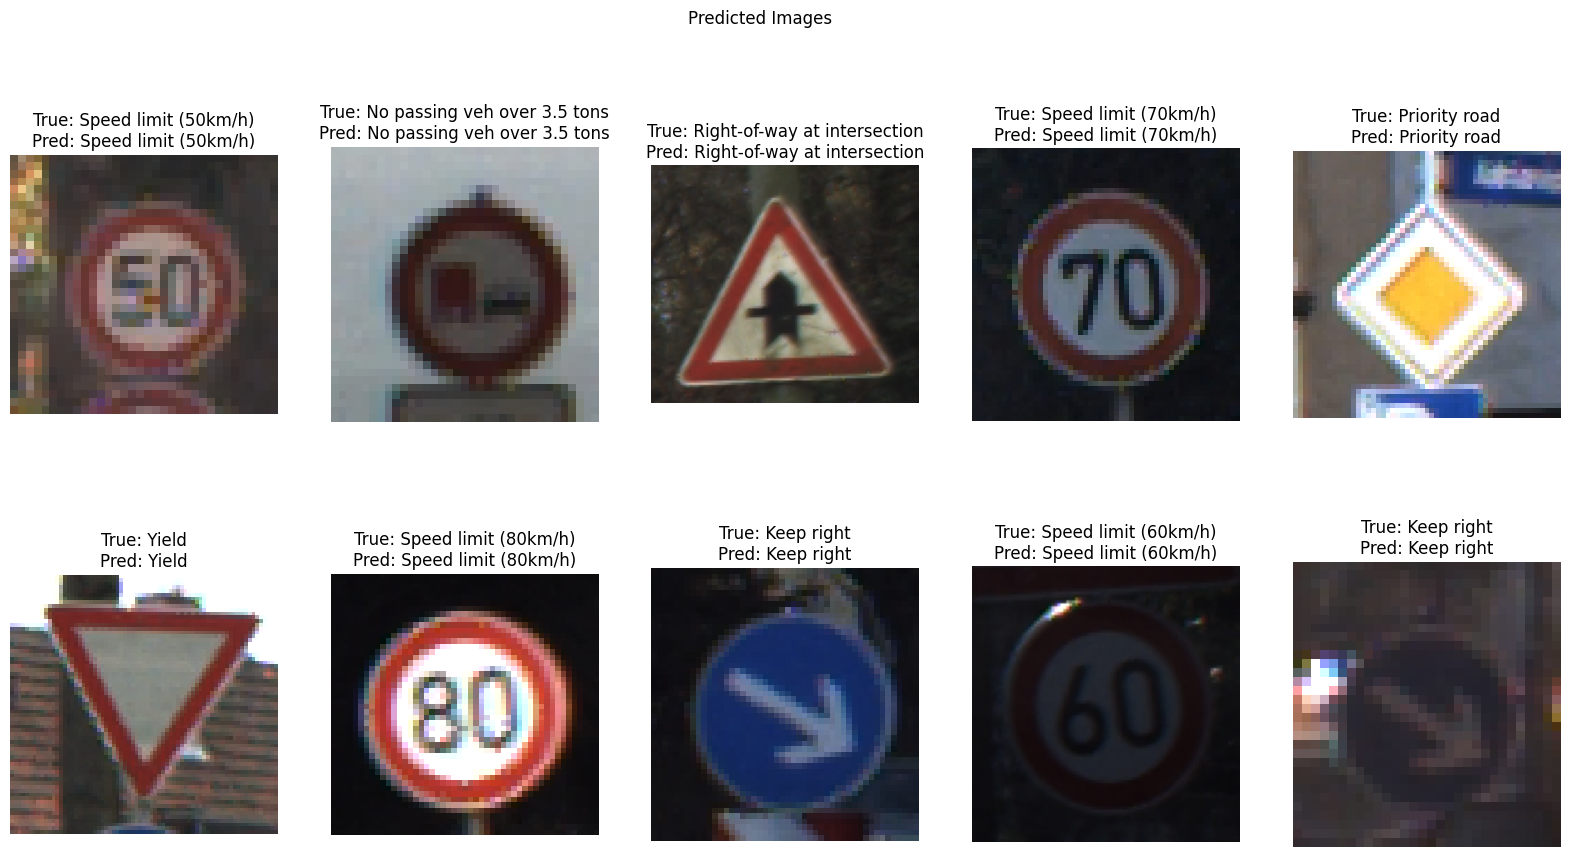

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB))
    ax.set_title(f'True: {CLASS_LABELS[test_labels[i]]}\nPred: {CLASS_LABELS[y_pred[i]]}')
    ax.axis('off')
plt.suptitle('Predicted Images')

plt.show()

### Log metrics and save model to WanDB

In [ ]:
wandb.log({
    'accuracy': classification_metrics['accuracy'],
    'precision': classification_metrics['precision'],
    'recall': classification_metrics['recall'],
    'f1_score': classification_metrics['f1_score']
})

with open("svm_model.pkl", "wb") as f:
    pickle.dump(svc, f)
wandb.save("svm_model.pkl")
wandb.finish()

accuracy,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.94885
f1_score,0.93688
precision,0.9489
recall,0.9284
